In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/unet

/content/drive/MyDrive/unet


In [ ]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Load dataset

In [ ]:
r = open('trainval.txt')
txt = r.read().split('\n')
r.close()
txt = txt[:-1]

name = []
species = []
for line in txt:
    line = line.split(' ')
    name.append(line[0])
    species.append(int(line[2]))

name_train, name_test = train_test_split(name, test_size=0.2, random_state=42)
name_train, name_valid = train_test_split(name_train, test_size=0.1, random_state=42)

In [ ]:
img_path = 'images/'
mask_path = 'trimaps/'

In [ ]:
def load_img(path, name):
    X = []
    count = 0
    while count < len(name):
        temp_x = []
        temp_name = []
        if count+200 < len(name):
            temp_name = name[count:count+200]
        else:
            temp_name = name[count:]
        
        cnt = 0
        for img in temp_name:
            x = cv2.imread(path+img+'.jpg', cv2.IMREAD_COLOR)
            x = cv2.resize(x, (224, 224))
            x = x.astype(np.float)
            x = np.reshape(x, (1, 224, 224, 3))
            if cnt == 0:
                temp_x = x
            else:
                temp_x = np.concatenate((temp_x, x), axis=0)
            cnt += 1
        if count == 0:
            X = temp_x
        else:
            X = np.concatenate((X, temp_x), axis=0)
        
        count += 200
        print(X.shape)

    return X/255

In [ ]:
def load_mask(path, name):
    Y = []
    count = 0
    while count < len(name):
        temp_y = []
        temp_name = []
        temp_species = []
        if count+200 < len(name):
            temp_name = name[count:count+200]
            temp_species = species[count:count+200]
        else:
            temp_name = name[count:]
            temp_species = species[count:count+200]
        
        cnt = 0
        for k in range(len(temp_name)):
            y = cv2.imread(path+temp_name[k]+'.png', cv2.IMREAD_GRAYSCALE)
            y = cv2.resize(y, (224, 224))
            
            # 1: cat, 0: dog, 2: background
            if temp_species[k] == 1:
                y = np.where(y != 3, y, 1)
                for i in range(y.shape[0]):
                    for j in range(y.shape[1]):
                        if y[i][j] == 3:
                            y[i][j] = 1
            else:
                y = np.where(y == 2, y, 0)
                for i in range(y.shape[0]):
                    for j in range(y.shape[1]):
                        if y[i][j] == 3 or y[i][j] == 1:
                            y[i][j] = 0
            
            y = y.astype(np.int)
            y = np.reshape(y, (1, 224, 224))
            if cnt == 0:
                temp_y = y
            else:
                temp_y = np.concatenate((temp_y, y), axis=0)
            cnt += 1
        if count == 0:
            Y = temp_y
        else:
            Y = np.concatenate((Y, temp_y), axis=0)
        
        count += 200
        print(Y.shape)

    return Y

In [ ]:
X = load_img(img_path, name)
y = load_mask(mask_path, name)

(200, 224, 224, 3)
(400, 224, 224, 3)
(600, 224, 224, 3)
(800, 224, 224, 3)
(1000, 224, 224, 3)
(1200, 224, 224, 3)
(1400, 224, 224, 3)
(1600, 224, 224, 3)
(1800, 224, 224, 3)
(2000, 224, 224, 3)
(2200, 224, 224, 3)
(2400, 224, 224, 3)
(2600, 224, 224, 3)
(2800, 224, 224, 3)
(3000, 224, 224, 3)
(3200, 224, 224, 3)
(3400, 224, 224, 3)
(3600, 224, 224, 3)
(3680, 224, 224, 3)
(200, 224, 224)
(400, 224, 224)
(600, 224, 224)
(800, 224, 224)
(1000, 224, 224)
(1200, 224, 224)
(1400, 224, 224)
(1600, 224, 224)
(1800, 224, 224)
(2000, 224, 224)
(2200, 224, 224)
(2400, 224, 224)
(2600, 224, 224)
(2800, 224, 224)
(3000, 224, 224)
(3200, 224, 224)
(3400, 224, 224)
(3600, 224, 224)
(3680, 224, 224)


In [ ]:
X_train = X[:2650]
y_train = y[:2650]

X_valid = X[2650:2944]
y_valid = y[2650:2944]

X_test = X[2944:]
y_test = y[2944:]

# Hyperparameter

In [ ]:
shape = (224, 224, 3)
num_classes = 3
lr = 1e-4
batch_size = 8
epochs = 30

In [ ]:
callbacks_unet = [
    ModelCheckpoint("unet.h5", save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True)
]

callbacks_resnet50_unet = [
    ModelCheckpoint("densenet121_unet.h5", save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Metrics function

In [ ]:
def visualize(image, predicted_mask, ground_truth):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].set_axis_off()

    ax[1].imshow(predicted_mask)
    ax[1].set_title('Predicted mask')
    ax[1].set_axis_off()

    ax[2].imshow(ground_truth)
    ax[2].set_title('Ground truth')
    ax[2].set_axis_off()

    plt.show()

In [ ]:
def iou(y_test, pred, type_pet):
    intersection = 0
    union = 0
    for i in range(y_test.shape[0]):
        for h in range(y_test.shape[1]):
            for w in range(y_test.shape[2]):
                if y_test[i][h][w] == type_pet or pred[i][h][w] == type_pet:
                    union += 1
                if y_test[i][h][w] == type_pet and pred[i][h][w] == type_pet:
                    intersection += 1
        
    return intersection / union

In [ ]:
def dice(y_test, pred, type_pet):
    gt_area = 0
    pr_area = 0
    intersection = 0
    for i in range(y_test.shape[0]):
        for h in range(y_test.shape[1]):
            for w in range(y_test.shape[2]):
                if y_test[i][h][w] == type_pet:
                    gt_area += 1
                if pred[i][h][w] == type_pet:
                    pr_area += 1
                if y_test[i][h][w] == type_pet and pred[i][h][w] == type_pet:
                    intersection += 1
    return 2 * intersection / (gt_area + pr_area)

# DenseNet121-Unet

## Define Model

In [ ]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [ ]:
def densenet121_unet(input_shape, num_classes):

    inputs = Input(input_shape)

    densenet = DenseNet121(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = densenet.get_layer("input_1").output
    s2 = densenet.get_layer("conv1/relu").output
    s3 = densenet.get_layer("pool2_relu").output
    s4 = densenet.get_layer("pool3_relu").output

    b1 = densenet.get_layer("pool4_relu").output

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, 1, padding="same", activation="softmax")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

In [ ]:
densenet121_unet_model = densenet121_unet(shape, num_classes)
densenet121_unet_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])
densenet121_unet_model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "ResNet50_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                    

## Training

In [ ]:
history = densenet121_unet_model.fit(x=X_train, y=y_train,
                                     batch_size=batch_size,
                                     validation_data=(X_valid, y_valid),
                                     epochs=epochs, callbacks=callbacks_resnet50_unet)

Epoch 1/30
332/332 [==============================] - 383s 1s/step - loss: 0.3241 - accuracy: 0.8791 - val_loss: 0.2297 - val_accuracy: 0.9257 - lr: 1.0000e-04
Epoch 2/30
332/332 [==============================] - 333s 1s/step - loss: 0.1734 - accuracy: 0.9429 - val_loss: 0.2797 - val_accuracy: 0.9127 - lr: 1.0000e-04
Epoch 3/30
332/332 [==============================] - 332s 1s/step - loss: 0.1470 - accuracy: 0.9514 - val_loss: 0.3436 - val_accuracy: 0.8899 - lr: 1.0000e-04
Epoch 4/30
332/332 [==============================] - 334s 1s/step - loss: 0.1184 - accuracy: 0.9593 - val_loss: 0.1861 - val_accuracy: 0.9361 - lr: 1.0000e-04
Epoch 5/30
332/332 [==============================] - 332s 1s/step - loss: 0.1100 - accuracy: 0.9619 - val_loss: 0.1728 - val_accuracy: 0.9388 - lr: 1.0000e-04
Epoch 6/30
332/332 [==============================] - 332s 1s/step - loss: 0.0972 - accuracy: 0.9664 - val_loss: 0.1711 - val_accuracy: 0.9426 - lr: 1.0000e-04
Epoch 7/30
332/332 [====================

## Result

In [ ]:
densenet121_unet_model = tf.keras.models.load_model('densenet121_unet.h5')
pred = densenet121_unet_model.predict(X_test)
pred = np.argmax(pred, axis=3)

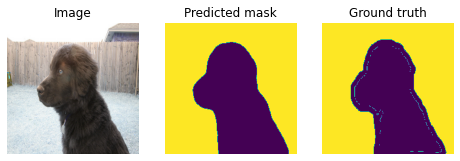

In [ ]:
visualize(X_test[20], pred[20], y_test[20])

In [ ]:
iou_cat = iou(y_test, pred, 1)
iou_dog = iou(y_test, pred, 0)
iou_bg = iou(y_test, pred, 2)

print(f'IOU cat: {iou_cat:.4f}')
print(f'IOU dog: {iou_dog:.4f}')

IOU cat: 0.8701
IOU dog: 0.8832


In [ ]:
dice_cat = dice(y_test, pred, 1)
dice_dog = dice(y_test, pred, 0)
dice_bg = dice(y_test, pred, 2)

print(f'Dice cat: {dice_cat:.4f}')
print(f'Dice dog: {dice_dog:.4f}')

Dice cat: 0.9305
Dice dog: 0.9380


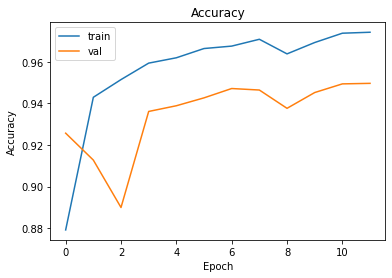

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

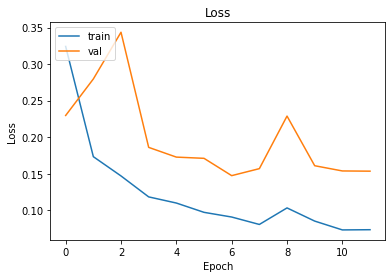

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()